## Image Classification of Album Cover Images

In [1]:
import numpy as np
import pandas as pd

import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchmetrics.classification import BinaryF1Score
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import os

!pip install -q torch-lr-finder
from torch_lr_finder import LRFinder

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Dataloaders and Datasets

In [2]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomPosterize(4, p = 0.25),
    transforms.ColorJitter(brightness = (0.15, 0.90)),
    transforms.RandomRotation(degrees = 15),
    transforms.ToTensor()
])

In [3]:
TRAIN_MERGED_PATH = "/kaggle/input/mumu-image-classification-album/mumu-images-classification/train"
TEST_MERGED_PATH = "/kaggle/input/mumu-image-classification-album/mumu-images-classification/test"

In [4]:
train_dataset = datasets.ImageFolder(TRAIN_MERGED_PATH, transform = transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True)

test_dataset = datasets.ImageFolder(TEST_MERGED_PATH, transform = transforms.ToTensor())
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle = True)

In [5]:
train_dataset[0][0].shape

torch.Size([3, 256, 256])

In [6]:
train_dataset.classes

['ai', 'human']

## Model

In [7]:
models.list_models(module=models)

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'googlenet',
 'inception_v3',
 'maxvit_t',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'regnet_x_16gf',
 'regnet_x_1_6gf',
 'regnet_x_32gf',
 'regnet_x_3_2gf',
 'regnet_x_400mf',
 'regnet_x_800mf',
 'regnet_x_8gf',
 'regnet_y_128gf',
 'regnet_y_16gf',
 'regnet_y_1_6gf',
 'regnet_y_32gf',
 'regnet_y_3_2gf',
 'regnet_y_400mf',
 'regnet_y_800mf',
 'regnet_y_8gf',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext101_64x4d',
 'resnext50_32x4d',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'sh

In [8]:
class CreativeNet(nn.Module):
    def __init__(self, train_baseline_classifier = False, num_output_classes = 2, dropout_rate = 0.20):
        super().__init__()
        
        # Set instance variables
        self.train_baseline_classifier = train_baseline_classifier
        self.num_outuput_classes = num_output_classes
        self.dropout_rate = dropout_rate
        
        # Set the current device for tensor calculations
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Baseline: MobileNet V3 small
        self.baseline = models.mobilenet_v3_small(weights = models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
        
        # Freeze the parameters of the base model (including but not limited to the last layers)
        for param in self.baseline.parameters():
            param.requires_grad = False
        
        if self.train_baseline_classifier:
            for param in self.baseline.classifier.parameters():
                param.requires_grad = True
                
        # Fully-connected block
        self.fc1 = nn.Linear(1000, 128)
        self.dropout1 = nn.Dropout(self.dropout_rate)
        self.fc2 = nn.Linear(128, 32)
        self.dropout2 = nn.Dropout(self.dropout_rate)
        self.fc3 = nn.Linear(32, self.num_outuput_classes)
        
    def forward(self, x):
        # Baseline
        x = x.to(self.device)
        x = self.baseline(x)
        
        # FC Block
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.leaky_relu(self.fc3(x))
        x = torch.sigmoid(x)
        return x

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

MODEL_ARGS = {
    "train_baseline_classifier" : False, 
    "num_output_classes" : len(train_dataset.classes),
    "dropout_rate" : 0.35
}

model = CreativeNet(**MODEL_ARGS).to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


Using device cuda


100%|██████████| 9.83M/9.83M [00:00<00:00, 79.5MB/s]


## Criterion and Optimiser

In [10]:
criterion = nn.CrossEntropyLoss()

  0%|          | 0/300 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.84E-02


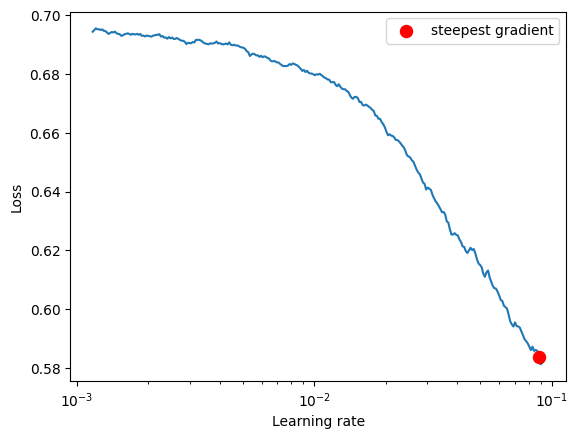

In [11]:
optimiser = optim.SGD(model.parameters(), lr = 0.001)
lr_finder = LRFinder(model, optimiser, criterion, device="cuda")
lr_finder.range_test(train_dataloader, end_lr=0.1, num_iter=300)

lr_finder.plot()
lr_finder.reset()

In [12]:
optimiser = optim.SGD(model.parameters(), lr = 8.84E-02)

## Metrics

In [13]:
metric = BinaryF1Score().to(device)

## Train and test the model

In [14]:
def train_test_loop(model, train_dataloader, test_dataloader, num_epochs = 100, save_prefix = "mumu_", verbose = False):
    # Save F1 scores and best model
    all_train_f1_scores = []
    all_test_f1_scores = []
    best_model = None
    candidate_f1_score = 0.0
    save_path = "fallback.pt"
    
    for epoch in tqdm(range(num_epochs)):
        # Training loop
        f1_scores = []
        model.train()
        for i, data in enumerate(train_dataloader, 0):
            # Load the inputs
            inputs, labels = data
            inputs = torch.Tensor(inputs).to(device)
            labels = torch.Tensor(labels).to(device)
                        
            # Forward + Backward + Optimise
            optimiser.zero_grad()
            outputs = model(inputs)
            outputs = torch.Tensor(outputs).to(device)
            loss = criterion(outputs, labels)
            loss.backward()
            optimiser.step()
            
            # Training metrics calculation
            output_classes = torch.argmax(outputs, dim = 1)
            output_classes = torch.Tensor(output_classes).to(device)
            f1_score = metric(output_classes, labels)
            f1_scores.append(f1_score)
            
        # Update best scores and best model
        average_f1_score = (sum(f1_scores)/len(f1_scores))
        all_train_f1_scores.append(average_f1_score)
        if average_f1_score > candidate_f1_score:
            candidate_f1_score = average_f1_score
            average_f1_score_print = float(average_f1_score.cpu().detach())
            save_path = f"{save_prefix}_train_{str(average_f1_score_print).replace('.','_')}.pt"
            
        # Testing loop
        test_f1_scores = []
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(test_dataloader, 0):
                # Load the inputs
                inputs, labels = data
                inputs = torch.Tensor(inputs).to(device)
                labels = torch.Tensor(labels).to(device)

                # Forward
                outputs = model(inputs)
                outputs = torch.Tensor(outputs).to(device)
                output_classes = torch.argmax(outputs, dim = 1)
                output_classes = torch.Tensor(output_classes).to(device)
                
                # Testing metrics calculation
                f1_score = metric(output_classes, labels)
                test_f1_scores.append(f1_score)
            average_test_f1_score = (sum(test_f1_scores)/len(test_f1_scores))
            all_test_f1_scores.append(average_test_f1_score)
            
        
        # Verbose output if warranted
        if verbose:
            current_train_f1_score = all_train_f1_scores[-1]
            current_test_f1_score = all_test_f1_scores[-1]
            print(f"Train F1: {current_train_f1_score}, Test F1: {current_test_f1_score}")
        
    # Save best model at the end of the training loop
    torch.save(model.state_dict(), save_path)

In [15]:
TRAIN_ARGS = {
    "model" : model,
    "train_dataloader" : train_dataloader,
    "test_dataloader" : test_dataloader,
    "num_epochs" : 50,
    "save_prefix" : "mumu_mobilenet_v3_s",
    "verbose" : True
}

In [16]:
train_test_loop(**TRAIN_ARGS)

  2%|▏         | 1/50 [00:03<02:45,  3.37s/it]

Train F1: 0.6570633053779602, Test F1: 0.6183761954307556


  4%|▍         | 2/50 [00:06<02:24,  3.01s/it]

Train F1: 0.7436091303825378, Test F1: 0.5229966044425964


  6%|▌         | 3/50 [00:08<02:09,  2.77s/it]

Train F1: 0.759015679359436, Test F1: 0.6628317832946777


  8%|▊         | 4/50 [00:11<02:01,  2.64s/it]

Train F1: 0.7635537385940552, Test F1: 0.7797648906707764


 10%|█         | 5/50 [00:13<01:55,  2.56s/it]

Train F1: 0.8098272085189819, Test F1: 0.6033951044082642


 12%|█▏        | 6/50 [00:16<01:53,  2.59s/it]

Train F1: 0.7937921285629272, Test F1: 0.7833402156829834


 14%|█▍        | 7/50 [00:18<01:52,  2.61s/it]

Train F1: 0.8140865564346313, Test F1: 0.7866029143333435


 16%|█▌        | 8/50 [00:21<01:48,  2.58s/it]

Train F1: 0.8201833963394165, Test F1: 0.7149722576141357


 18%|█▊        | 9/50 [00:23<01:45,  2.56s/it]

Train F1: 0.8614245057106018, Test F1: 0.7362258434295654


 20%|██        | 10/50 [00:26<01:41,  2.53s/it]

Train F1: 0.8432098627090454, Test F1: 0.7914058566093445


 22%|██▏       | 11/50 [00:28<01:39,  2.55s/it]

Train F1: 0.8634525537490845, Test F1: 0.7339473962783813


 24%|██▍       | 12/50 [00:31<01:38,  2.60s/it]

Train F1: 0.8769017457962036, Test F1: 0.8139820098876953


 26%|██▌       | 13/50 [00:34<01:35,  2.57s/it]

Train F1: 0.8442805409431458, Test F1: 0.7956539392471313


 28%|██▊       | 14/50 [00:36<01:34,  2.63s/it]

Train F1: 0.8450130224227905, Test F1: 0.7934216260910034


 30%|███       | 15/50 [00:39<01:31,  2.63s/it]

Train F1: 0.8555203080177307, Test F1: 0.8149773478507996


 32%|███▏      | 16/50 [00:41<01:27,  2.58s/it]

Train F1: 0.8650924563407898, Test F1: 0.8092018961906433


 34%|███▍      | 17/50 [00:44<01:24,  2.55s/it]

Train F1: 0.8800709843635559, Test F1: 0.807834804058075


 36%|███▌      | 18/50 [00:47<01:21,  2.56s/it]

Train F1: 0.8958112597465515, Test F1: 0.7132411003112793


 38%|███▊      | 19/50 [00:49<01:18,  2.54s/it]

Train F1: 0.8627311587333679, Test F1: 0.8571712970733643


 40%|████      | 20/50 [00:51<01:15,  2.53s/it]

Train F1: 0.8955748677253723, Test F1: 0.8157727122306824


 42%|████▏     | 21/50 [00:54<01:13,  2.52s/it]

Train F1: 0.8913940191268921, Test F1: 0.856824517250061


 44%|████▍     | 22/50 [00:56<01:10,  2.51s/it]

Train F1: 0.89802485704422, Test F1: 0.8933801054954529


 46%|████▌     | 23/50 [00:59<01:07,  2.49s/it]

Train F1: 0.9097707271575928, Test F1: 0.8792869448661804


 48%|████▊     | 24/50 [01:01<01:04,  2.48s/it]

Train F1: 0.9021252989768982, Test F1: 0.8704077005386353


 50%|█████     | 25/50 [01:04<01:02,  2.51s/it]

Train F1: 0.9015892148017883, Test F1: 0.8995684385299683


 52%|█████▏    | 26/50 [01:07<01:00,  2.52s/it]

Train F1: 0.8807693123817444, Test F1: 0.9257351160049438


 54%|█████▍    | 27/50 [01:09<00:58,  2.53s/it]

Train F1: 0.8989163041114807, Test F1: 0.8448399901390076


 56%|█████▌    | 28/50 [01:12<00:55,  2.53s/it]

Train F1: 0.9145943522453308, Test F1: 0.8988363742828369


 58%|█████▊    | 29/50 [01:14<00:53,  2.56s/it]

Train F1: 0.9228268265724182, Test F1: 0.9156851768493652


 60%|██████    | 30/50 [01:17<00:51,  2.55s/it]

Train F1: 0.9160486459732056, Test F1: 0.9177183508872986


 62%|██████▏   | 31/50 [01:19<00:48,  2.53s/it]

Train F1: 0.8818489909172058, Test F1: 0.8927749395370483


 64%|██████▍   | 32/50 [01:22<00:45,  2.54s/it]

Train F1: 0.9121420979499817, Test F1: 0.9181118011474609


 66%|██████▌   | 33/50 [01:24<00:43,  2.54s/it]

Train F1: 0.9166052937507629, Test F1: 0.9181851148605347


 68%|██████▊   | 34/50 [01:27<00:40,  2.54s/it]

Train F1: 0.9269716739654541, Test F1: 0.9185628294944763


 70%|███████   | 35/50 [01:29<00:37,  2.53s/it]

Train F1: 0.8905711770057678, Test F1: 0.9115784168243408


 72%|███████▏  | 36/50 [01:32<00:36,  2.58s/it]

Train F1: 0.896963357925415, Test F1: 0.9158848524093628


 74%|███████▍  | 37/50 [01:35<00:33,  2.54s/it]

Train F1: 0.919474184513092, Test F1: 0.9221019148826599


 76%|███████▌  | 38/50 [01:37<00:30,  2.51s/it]

Train F1: 0.9135531783103943, Test F1: 0.9057885408401489


 78%|███████▊  | 39/50 [01:40<00:28,  2.59s/it]

Train F1: 0.9231716394424438, Test F1: 0.8986483812332153


 80%|████████  | 40/50 [01:42<00:25,  2.56s/it]

Train F1: 0.9005178809165955, Test F1: 0.9016911387443542


 82%|████████▏ | 41/50 [01:45<00:22,  2.53s/it]

Train F1: 0.9158358573913574, Test F1: 0.9100024700164795


 84%|████████▍ | 42/50 [01:47<00:20,  2.52s/it]

Train F1: 0.9242138266563416, Test F1: 0.9134175181388855


 86%|████████▌ | 43/50 [01:50<00:17,  2.49s/it]

Train F1: 0.9003815650939941, Test F1: 0.8644752502441406


 88%|████████▊ | 44/50 [01:52<00:15,  2.50s/it]

Train F1: 0.9182119965553284, Test F1: 0.919052004814148


 90%|█████████ | 45/50 [01:55<00:12,  2.52s/it]

Train F1: 0.9230985045433044, Test F1: 0.8993214964866638


 92%|█████████▏| 46/50 [01:57<00:10,  2.51s/it]

Train F1: 0.9129446148872375, Test F1: 0.9181793928146362


 94%|█████████▍| 47/50 [02:00<00:07,  2.48s/it]

Train F1: 0.9282505512237549, Test F1: 0.9054268598556519


 96%|█████████▌| 48/50 [02:02<00:04,  2.47s/it]

Train F1: 0.9322514533996582, Test F1: 0.9016733169555664


 98%|█████████▊| 49/50 [02:04<00:02,  2.46s/it]

Train F1: 0.9191247820854187, Test F1: 0.9007848501205444


100%|██████████| 50/50 [02:07<00:00,  2.55s/it]

Train F1: 0.9142366051673889, Test F1: 0.9117023944854736
